## 数据集为：‘skin_benchmarks’，使用PyOD库中各类算法进行异常检测，并比较各类算法的优劣。

In [14]:
import pandas as pd
import os
import numpy as np
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.model_selection import train_test_split
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

### 进行数据预处理，将'nominal'和 'anomaly': 分别映射为‘0’和‘1’，并提取'R','G','B', 'diff.score'为特征，'ground.truth'为lable

In [15]:
label_mapping = {
           'nominal': 0,
           'anomaly': 1}
col_n = ['R','G','B','diff.score','original.label','ground.truth']

### 采用PYOD库中6种算法，分别为k-Nearest Neighbors Detector，Average KNN，Isolation Forest，Histogram-based Outlier Detection，Feature Bagging，Clustering Based Local Outlier Factor

In [16]:
# Define seven outlier detection tools to be compared
classifiers = {
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(check_estimator=False),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),check_estimator=False),
        'Histogram-base Outlier Detection (HBOS)': HBOS(),
        'Isolation Forest': IForest(),
        'K Nearest Neighbors (KNN)': KNN(),
        'Average KNN': KNN(method='mean')
}

### 数据集包括近1800个CSV文件，首先读取目录下所有数据文件

In [17]:
Roc_train=[]
Roc_test=[]
Prn_train=[]
Prn_test=[]

path='C:/Users/ThinkPad/Desktop/dm-data/skin/benchmarks'
files= os.listdir(path)

### 分别用PYOD里6种算法对所有进1800个数据进行预测，每一份数据文件按照80%为训练集，20%为测试集进行划分，针对训练集和测试集分别计算Roc和precision @ rank n两项指标,并抽样显示。

In [18]:
a=0
for file in files: 
    
    
    df = pd.read_csv(path+'/'+file)
   
    df['ground.truth'] = df['ground.truth'].map(label_mapping)
    #df = df.replace([np.inf, -np.inf], np.nan)
    #print(data.isnull().sum())
    #df.dropna()
    
    data = pd.DataFrame(df,columns = col_n)
    
      
    x = data.iloc[:, :-1]
    y = data.iloc[:, -1:]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    roc_train=[]
    roc_test=[]
    prn_train=[]
    prn_test=[]
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(x_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores
        
        # get the prediction on the test data
        y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(x_test)  # outlier scores
        
        #roc_train.append(roc_auc_score(y_train, y_train_scores))
        #roc_test.append(roc_auc_score(y_test, y_test_scores))
        
        prn_train.append(precision_n_scores(y_train, y_train_scores))
        prn_test.append(precision_n_scores(y_test, y_test_scores))
    
    a=a+1
    if a%100==0:
        print('数据文件：',file, '，其测试集ROC为:',np.round(prn_test, decimals=3))    
    #Roc_train.append(roc_train)
    #Roc_test.append(roc_test)
    Prn_train.append(prn_train)
    Prn_test.append(prn_test)

数据文件： skin_benchmark_0100.csv ，其测试集ROC为: [0.4   0.071 0.385 0.443 0.286 0.29 ]
数据文件： skin_benchmark_0200.csv ，其测试集ROC为: [0.067 0.206 0.824 0.504 0.13  0.134]
数据文件： skin_benchmark_0300.csv ，其测试集ROC为: [0.594 0.63  0.559 0.559 0.565 0.565]
数据文件： skin_benchmark_0400.csv ，其测试集ROC为: [0. 0. 0. 0. 0. 0.]
数据文件： skin_benchmark_0500.csv ，其测试集ROC为: [0. 0. 1. 0. 1. 1.]
数据文件： skin_benchmark_0660.csv ，其测试集ROC为: [0.    0.    0.333 1.    0.143 0.   ]
数据文件： skin_benchmark_0760.csv ，其测试集ROC为: [0.    0.    1.    0.286 0.143 0.286]
数据文件： skin_benchmark_0920.csv ，其测试集ROC为: [0.    0.    0.333 0.833 0.    0.   ]
数据文件： skin_benchmark_1020.csv ，其测试集ROC为: [0.    0.412 0.25  0.412 0.059 0.176]
数据文件： skin_benchmark_1120.csv ，其测试集ROC为: [0.    0.75  0.833 0.833 0.167 0.167]
数据文件： skin_benchmark_1280.csv ，其测试集ROC为: [0.    0.    0.278 0.407 0.111 0.13 ]
数据文件： skin_benchmark_1380.csv ，其测试集ROC为: [0.078 0.047 0.75  0.859 0.219 0.188]
数据文件： skin_benchmark_1540.csv ，其测试集ROC为: [0.551 0.    0.315 0.433 0.15  0.165]
数据文件： ski

### 计算6种算法两项指标的的平均值

In [19]:
#Roc_train=np.round(np.mean(Roc_train,axis=0), decimals=3)
#Roc_test=np.round(np.mean(Roc_test,axis=0), decimals=3)
Prn_train=np.round(np.mean(Prn_train,axis=0), decimals=3)
Prn_test=np.round(np.mean(Prn_test,axis=0), decimals=3)

### 从结果可以看出，训练集两项指标略优于测试集，Isolation Forest，Histogram-based Outlier Detection优于其他算法，其中Histogram-based Outlier Detection算法最优

In [20]:
#print('Roc_train:',Roc_train)
#print('Roc_test:',Roc_test)
print('Prn_train:',Prn_train)
print('Prn_test:',Prn_test)

Prn_train: [0.126 0.141 0.564 0.481 0.213 0.25 ]
Prn_test: [0.128 0.136 0.566 0.479 0.253 0.278]


### 通过柱状图进行直观比较各类算法Prn的具体表现

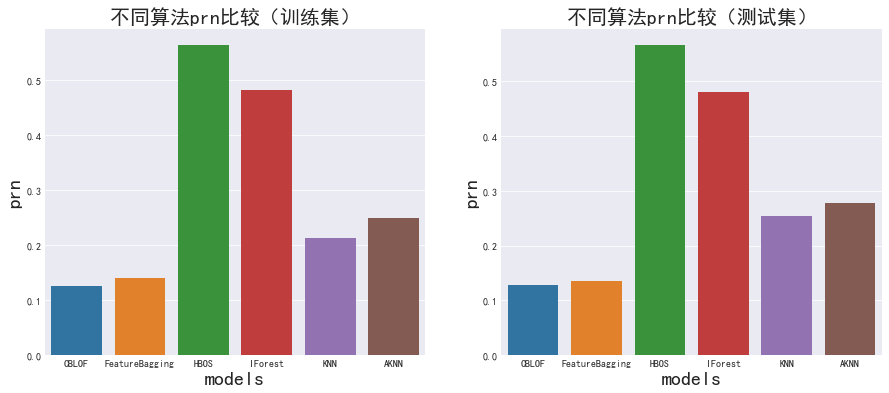

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

x=['CBLOF','FeatureBagging','HBOS','IForest','KNN','AKNN']

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
#sns.barplot(x, Roc_train,ax=ax1)
#sns.barplot(x, Roc_test,ax=ax1)
sns.barplot(x, Prn_train,ax=ax1)
sns.barplot(x, Prn_test,ax=ax2)
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('darkgrid', {'font.sans-serif':['SimHei', 'Arial']})

ax1.set_xlabel('models', fontsize=20)
ax1.set_ylabel('prn', fontsize=20)
ax1.set_title('不同算法prn比较（训练集）',fontsize=20)
ax2.set_xlabel('models', fontsize=20)
ax2.set_ylabel('prn', fontsize=20)
ax2.set_title('不同算法prn比较（测试集）',fontsize=20)

plt.show()